In [ ]:
import numpy as np
! pip install sklearn-pandas
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

! pip install torchtuples
import torch
import torchtuples as tt

! pip install pycox
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

     |████████████████████████████████| 41 kB 578 kB/s 
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 357 kB 61.3 MB/s 
     |████████████████████████████████| 48 kB 5.5 MB/s 
     |████████████████████████████████| 2.8 MB 45.5 MB/s 
     |████████████████████████████████| 126 kB 60.6 MB/s 
     |████████████████████████████████| 1.9 MB 59.7 MB/s 


In [ ]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [ ]:
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_                = pd.read_csv('pbc2_cleaned.csv')

    bin_list           = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders']
    cont_list          = ['age', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic']
    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

In [ ]:
df = pd.read_csv('pbc2_cleaned.csv')

DIM, DATA, MASK, data_mi = import_dataset()

In [ ]:
labels = np.reshape(DATA[2],-1)
time = np.reshape(DATA[1],-1)

In [ ]:
for i in range(312):
  if labels[i] == 2:
    labels[i] = 0

In [ ]:
features = np.zeros([312,256])
for id in range(312):
    features[id] = np.reshape(DATA[0][id],-1)

In [ ]:
X = pd.DataFrame(features)
X['duration'] = time
X['event'] = labels

In [ ]:
df_train = X

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_all = X

In [ ]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,duration,event
0,28.0,0.944976,2.581683,2.015877,-0.356880,-1.570646,0.281173,0.195488,-0.447383,0.813132,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.944976,2.581683,3.281890,0.0,-0.894575,0.192493,-1.485263,-0.519077,0.136768,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,1.0
1,26.0,0.714442,-0.575421,-0.478914,-0.110845,1.491559,5.030580,-0.116943,-0.129880,-0.269050,-0.304016,1.0,0.0,0.0,1.0,1.0,26.0,0.714442,-0.575421,-0.534768,0.0,0.417798,0.606612,0.214616,-0.467867,0.001495,-0.304016,1.0,0.0,0.0,1.0,1.0,58.0,0.714442,-0.575421,-0.497532,0.000000,0.318376,0.275317,0.274552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,736.0,0.0
2,26.0,2.069065,1.003131,-0.423061,-0.866954,0.179185,-0.724426,-0.338833,-0.846822,0.677859,0.841936,1.0,1.0,0.0,0.0,0.0,26.0,2.069065,-0.575421,-0.478914,0.0,-0.198620,-0.860793,-0.674218,-0.754643,0.677859,0.841936,1.0,1.0,0.0,1.0,1.0,54.0,2.069065,1.003131,-0.404443,-0.524905,0.358145,-0.973735,-0.832346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,1.0
3,27.0,0.544876,1.003131,-0.348589,-0.458895,-1.689953,3.965582,-0.791539,-0.519077,-0.471960,0.841936,1.0,0.0,0.0,1.0,1.0,26.0,0.544876,1.003131,-0.385825,0.0,-1.013882,-0.173104,0.590808,0.064718,5.412408,0.841936,1.0,0.0,0.0,1.0,1.0,51.0,0.544876,1.003131,-0.367207,0.000000,-1.172958,-0.188162,0.551276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,1.0
4,29.0,-1.108870,-0.575421,-0.050704,-0.248865,0.278607,-0.594753,-0.120769,-1.000452,-0.066141,-0.304016,0.0,0.0,0.0,1.0,1.0,27.0,-1.108870,-0.575421,-0.329971,0.0,-0.218504,-0.579694,-0.239365,-1.225776,-0.201414,-0.304016,0.0,0.0,0.0,1.0,0.0,54.0,-1.108870,1.003131,-0.218264,0.000000,-0.099197,-0.610648,-0.062109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0


In [ ]:
cols_standardize = []
cols_leave = []
for i in df_train.columns[:-2]:
  if i%16 < 11 and i%16 > 0:
    cols_standardize.append(i)

  else:
    cols_leave.append(i)


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_all = x_mapper.transform(df_all).astype('float32')

In [ ]:
np.shape(x_train)

(200, 256)

In [ ]:
class LabTransCoxTime:
    """
    Label transforms useful for CoxTime models. It can log-transform and standardize the durations.
    It also creates `map_scaled_to_orig` which is the inverse transform of the durations data,
    enabling us to set the correct time scale for predictions.
    This can be done by passing the object to the CoxTime init:
        model = CoxTime(net, labrans=labtrans)
    which gives the correct time scale of survival predictions
        surv = model.predict_surv_df(x)
    
    Keyword Arguments:
        log_duration {bool} -- Log-transform durations, i.e. 'log(1+x)'. (default: {False})
        with_mean {bool} -- Center the duration before scaling.
            Passed to `sklearn.preprocessing.StandardScaler` (default: {True})
        with_std {bool} -- Scale duration to unit variance.
            Passed to `sklearn.preprocessing.StandardScaler` (default: {True})
    """
    def __init__(self, log_duration=False, with_mean=True, with_std=True):
        self.log_duration = log_duration
        self.duration_scaler = StandardScaler()

    @property
    def map_scaled_to_orig(self):
        """Map from transformed durations back to the original durations, i.e. inverse transform.
        Use it to e.g. set index of survival predictions:
            surv = model.predict_surv_df(x_test)
            surv.index = labtrans.map_scaled_to_orig(surv.index)
        """
        if not hasattr(self, '_inverse_duration_map'):
            raise ValueError('Need to fit the models before you can call this method')
        return self._inverse_duration_map

    def fit(self, durations, events):
        self.fit_transform(durations, events)
        return self

    def fit_transform(self, durations, events):
        train_durations = durations
        durations = durations.astype('float32')
        events = events.astype('float32')
        if self.log_duration:
            durations = np.log1p(durations)
        durations = self.duration_scaler.fit_transform(durations.reshape(-1, 1)).flatten()
        self._inverse_duration_map = {scaled: orig for orig, scaled in zip(train_durations, durations)}
        self._inverse_duration_map = np.vectorize(self._inverse_duration_map.get)
        return durations, events

    def transform(self, durations, events):
        durations = durations.astype('float32')
        events = events.astype('float32')
        if self.log_duration:
            durations = np.log1p(durations)
        durations = self.duration_scaler.transform(durations.reshape(-1, 1)).flatten()
        return durations, events

    @property
    def out_features(self):
        """Returns the number of output features that should be used in the torch model.
        This always returns 1, and is just included for api design purposes.
        
        Returns:
            [int] -- Number of output features.
        """
        return 1


In [ ]:
event_time = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]

In [ ]:
labtrans = LabTransCoxTime(event_time)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [ ]:
val.shapes()

((50, 256), ((50,), (50,)))

In [ ]:
val.repeat(2).cat().shapes() 

((100, 256), ((100,), (100,)))

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [ ]:
??MLPVanillaCoxTime

In [ ]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

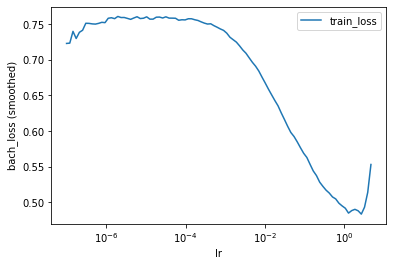

In [ ]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.2718588242732959

In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

0:	[0s / 0s],		train_loss: 0.7543,	val_loss: 0.6150
1:	[0s / 0s],		train_loss: 0.5993,	val_loss: 0.5628
2:	[0s / 0s],		train_loss: 0.5072,	val_loss: 0.5959
3:	[0s / 0s],		train_loss: 0.4724,	val_loss: 0.4992
4:	[0s / 0s],		train_loss: 0.5377,	val_loss: 0.4636
5:	[0s / 0s],		train_loss: 0.4129,	val_loss: 0.5378
6:	[0s / 0s],		train_loss: 0.4111,	val_loss: 0.4663
7:	[0s / 0s],		train_loss: 0.3113,	val_loss: 0.4457
8:	[0s / 0s],		train_loss: 0.3170,	val_loss: 0.4416
9:	[0s / 0s],		train_loss: 0.3113,	val_loss: 0.3952
10:	[0s / 0s],		train_loss: 0.2898,	val_loss: 0.3911
11:	[0s / 0s],		train_loss: 0.3533,	val_loss: 0.3861
12:	[0s / 0s],		train_loss: 0.2722,	val_loss: 0.3602
13:	[0s / 0s],		train_loss: 0.2258,	val_loss: 0.3965
14:	[0s / 0s],		train_loss: 0.3067,	val_loss: 0.3279
15:	[0s / 0s],		train_loss: 0.2430,	val_loss: 0.3475
16:	[0s / 0s],		train_loss: 0.2694,	val_loss: 0.3553
17:	[0s / 0s],		train_loss: 0.3033,	val_loss: 0.3411
18:	[0s / 0s],		train_loss: 0.2095,	val_loss: 0.3244
19:

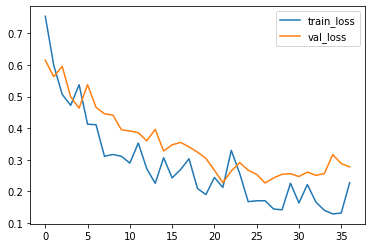

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*val).mean()

-2.000563474431109

In [ ]:
_ = model.compute_baseline_hazards()

In [ ]:
surv = model.predict_surv_df(x_all)

In [ ]:
??model.predict_surv_df

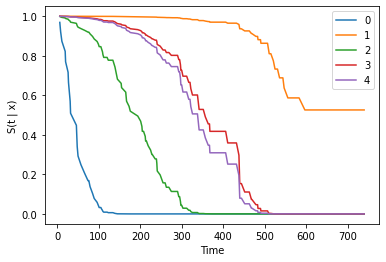

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
surv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311
6.0,0.968860,0.999996,9.986513e-01,9.998772e-01,9.998494e-01,0.999988,0.999996,0.999991,0.999934,9.751037e-01,0.999989,9.966977e-01,1.000000,9.998179e-01,0.999986,1.000000,9.958988e-01,0.941817,1.000000,9.969986e-01,0.999981,9.966778e-01,0.969324,0.999999,1.000000,9.992022e-01,0.958697,0.953503,1.000000,0.983930,0.999997,1.000000,0.999995,1.000000,9.996809e-01,1.000000,0.970252,0.999995,0.999988,1.00000,...,0.999976,9.999148e-01,0.999988,0.999920,0.999970,9.996375e-01,0.999992,0.999982,0.717457,0.999931,9.996879e-01,0.999987,0.999992,0.999706,9.985307e-01,0.999889,9.991252e-01,0.999973,9.985480e-01,9.975930e-01,9.934416e-01,9.995698e-01,0.999928,0.999973,9.979077e-01,0.999974,0.999823,9.940825e-01,0.999920,0.999996,9.983390e-01,0.999971,9.997332e-01,0.999899,0.999987,0.999975,0.999943,9.998310e-01,9.998258e-01,9.995232e-01
8.0,0.922119,0.999990,9.965194e-01,9.996812e-01,9.996073e-01,0.999969,0.999990,0.999976,0.999828,9.397304e-01,0.999972,9.916618e-01,1.000000,9.995271e-01,0.999964,0.999999,9.895745e-01,0.863667,1.000000,9.922653e-01,0.999951,9.914848e-01,0.923686,0.999997,0.999999,9.979284e-01,0.901373,0.885177,0.999999,0.959349,0.999992,1.000000,0.999987,1.000000,9.991786e-01,1.000000,0.925872,0.999988,0.999969,1.00000,...,0.999940,9.997785e-01,0.999969,0.999800,0.999922,9.990665e-01,0.999978,0.999952,0.440874,0.999831,9.991934e-01,0.999966,0.999981,0.999274,9.962154e-01,0.999727,9.977350e-01,0.999929,9.962569e-01,9.938337e-01,9.838946e-01,9.988824e-01,0.999823,0.999933,9.946426e-01,0.999935,0.999590,9.850946e-01,0.999800,0.999989,9.957110e-01,0.999929,9.993089e-01,0.999748,0.999965,0.999934,0.999850,9.995605e-01,9.995519e-01,9.987647e-01
11.0,0.873778,0.999983,9.941684e-01,9.994627e-01,9.993351e-01,0.999948,0.999983,0.999960,0.999709,9.052332e-01,0.999952,9.863323e-01,0.999999,9.992027e-01,0.999938,0.999999,9.827973e-01,0.792311,1.000000,9.870607e-01,0.999918,9.858324e-01,0.876936,0.999994,0.999998,9.965074e-01,0.847036,0.816393,0.999999,0.933303,0.999986,1.000000,0.999979,1.000000,9.986272e-01,1.000000,0.880273,0.999979,0.999948,1.00000,...,0.999902,9.996259e-01,0.999949,0.999677,0.999868,9.984393e-01,0.999963,0.999919,0.269241,0.999729,9.986463e-01,0.999942,0.999971,0.998833,9.936711e-01,0.999564,9.961924e-01,0.999881,9.937353e-01,9.897449e-01,9.743296e-01,9.981149e-01,0.999719,0.999891,9.910943e-01,0.999895,0.999383,9.756298e-01,0.999677,0.999982,9.928096e-01,0.999888,9.988375e-01,0.999595,0.999941,0.999889,0.999746,9.992586e-01,9.992517e-01,9.979218e-01
19.0,0.822403,0.999975,9.914589e-01,9.992061e-01,9.990114e-01,0.999922,0.999975,0.999941,0.999571,8.723852e-01,0.999929,9.806113e-01,0.999999,9.988214e-01,0.999908,0.999999,9.753522e-01,0.729390,1.000000,9.810835e-01,0.999878,9.794548e-01,0.828124,0.999992,0.999997,9.948397e-01,0.796874,0.745483,0.999998,0.904890,0.999979,1.000000,0.999968,1.000000,9.979976e-01,1.000000,0.832565,0.999969,0.999923,1.00000,...,0.999865,9.994458e-01,0.999929,0.999553,0.999805,9.977223e-01,0.999945,0.999880,0.165277,0.999628,9.980129e-01,0.999914,0.999961,0.998393,9.907569e-01,0.999403,9.943958e-01,0.999823,9.908394e-01,9.851422e-01,9.652338e-01,9.972116e-01,0.999619,0.999846,9.872076e-01,0.999855,0.999229,9.655289e-01,0.999556,0.999973,9.894584e-01,0.999850,9.982878e-01,0.999444,0.999912,0.999834,0.999623,9.989035e-01,9.989101e-01,9.969382e-01
20.0,0.769491,0.999966,9.884863e-01,9.989234e-01,9.986544e-01,0.999893,0.999965,0.999919,0.999418,8.381247e-01,0.999904,9.743954e-01,0.999998,9.984014e-01,0.999875,0.999998,9.672594e-01,0.666984,1.000000,9.745492e-01,0.999834,9.724971e-01,0.777772,0.999989,0.999996,9.930052e-01,0.745880,0.674741,0.999997,0.874706,0.999972,1.000000,0.999957,1.000000,9.973062e-01,1.000000,0.783268,0

In [ ]:
z = surv.transpose()

In [ ]:
z

,6.0,8.0,11.0,19.0,20.0,26.0,27.0,29.0,31.0,32.0,46.0,47.0,48.0,50.0,57.0,66.0,74.0,76.0,79.0,85.0,89.0,96.0,99.0,101.0,105.0,107.0,109.0,110.0,112.0,120.0,123.0,125.0,129.0,134.0,139.0,143.0,145.0,154.0,155.0,165.0,...,483.0,484.0,490.0,491.0,501.0,507.0,509.0,511.0,515.0,521.0,525.0,531.0,536.0,537.0,544.0,547.0,556.0,557.0,565.0,572.0,583.0,597.0,605.0,606.0,610.0,619.0,624.0,644.0,656.0,670.0,672.0,690.0,691.0,702.0,726.0,730.0,731.0,732.0,736.0,740.0
0,0.968860,0.922119,0.873778,0.822403,0.769491,0.716644,0.664723,0.615848,0.570228,0.509206,0.448280,0.391134,0.340355,0.292634,0.248749,0.205017,0.168310,0.168310,0.137931,0.103802,0.078070,0.058608,0.043608,0.032322,0.032322,0.023919,0.017458,0.012580,0.008943,0.008943,0.006334,0.006334,0.006334,0.006334,0.002746,0.000959,0.000542,0.000302,0.000164,0.000084,...,3.096265e-208,1.393996e-242,1.393996e-242,3.974941e-281,3.974941e-281,3.974941e-281,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.999996,0.999990,0.999983,0.999975,0.999966,0.999956,0.999945,0.999934,0.999923,0.999907,0.999888,0.999867,0.999846,0.999823,0.999798,0.999767,0.999736,0.999736,0.999703,0.999656,0.999609,0.999560,0.999510,0.999459,0.999459,0.999406,0.999352,0.999295,0.999235,0.999235,0.999174,0.999174,0.999174,0.999174,0.999022,0.998829,0.998724,0.998616,0.998502,0.998376,...,8.979913e-01,8.814995e-01,8.814995e-01,8.632996e-01,8.632996e-01,8.632996e-01,8.383510e-01,8.103919e-01,8.103919e-01,7.748806e-01,7.327839e-01,7.327839e-01,6.883241e-01,6.883241e-01,6.883241e-01,6.372286e-01,5.868788e-01,5.868788e-01,5.868788e-01,5.868788e-01,5.868788e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01,5.259706e-01
2,0.998651,0.996519,0.994168,0.991459,0.988486,0.985275,0.981885,0.978442,0.974973,0.969887,0.964066,0.957865,0.951573,0.944762,0.937415,0.928645,0.919700,0.919700,0.910691,0.897852,0.885088,0.872294,0.859242,0.846185,0.846185,0.833157,0.819711,0.805932,0.791799,0.791799,0.777584,0.777584,0.777584,0.777584,0.743636,0.702857,0.681666,0.660439,0.638815,0.615948,...,1.551710e-13,1.025111e-15,1.025111e-15,3.625017e-18,3.625017e-18,3.625017e-18,1.322283e-21,1.398717e-25,1.398717e-25,7.946084e-31,2.313479e-37,2.313479e-37,1.122408e-44,1.122408e-44,1.122408e-44,1.118095e-53,2.833471e-63,2.833471e-63,2.833471e-63,2.833471e-63,2.833471e-63,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76,5.432517e-76
3,0.999877,0.999681,0.999463,0.999206,0.998923,0.998615,0.998287,0.997953,0.997615,0.997116,0.996536,0.995914,0.995279,0.994586,0.993830,0.992917,0.991974,0.991974,0.991013,0.989626,0.988228,0.986804,0.985331,0.983835,0.983835,0.982319,0.980731,0.979079,0.977357,0.977357,0.975591,0.975591,0.975591,0.975591,0.971236,0.965755,0.962792,0.959733,0.956524,0.953016,...,4.667716e-02,2.761169e-02,2.761169e-02,1.529564e-02,1.529564e-02,1.529564e-02,6.673720e-03,2.557329e-03,2.557329e-03,7.207198e-04,1.486870e-04,1.486870e-04,2.538714e-05,2.538714e-05,2.538714e-05,2.878588e-06,2.823218e-07,2.823218e-07,2.823218e-07,2.823218e-07,2.823218e-07,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.291401e-08,1.2

In [ ]:
times_ = []
for t in event_time:
  for i in z.columns:
    if i >= t:
      times_.append(i)
      break


In [ ]:
np.shape(times_)

(113,)

In [ ]:
cox_time_predictions = {}

for patient in range(312):
  surv_data = np.zeros(113)
  i = 0
  for t in times_:
    surv_data[i] = surv[patient][t]
    i += 1
  cox_time_predictions[patient] = surv_data

In [ ]:
np.shape(cox_time_predictions[0])

(113,)

In [ ]:
import pickle
pickle.dump( cox_time_predictions, open( "cox_time.p", "wb" ) )